In [1]:
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import random
from sklearn.utils import shuffle
import math

In [2]:
%matplotlib inline
def displayImg(Xset, yset, n_img=8):

    imgIndex = np.random.randint(0,len(Xset), n_img)
    
    img_cnt =1
    plt.figure(figsize=(15, 5))    
    print(Xset.shape)           
    for row in range(1,5):
        for col in range(1,3):
            plt.subplot(2, 4, img_cnt)           
            plt.title('Ste: ' + '{:04.2f}'.format(yset[imgIndex[img_cnt-1]]) + ' #img:' + str(imgIndex[img_cnt-1]))
#             rgbImg = cv2.cvtColor(Xset[imgIndex[img_cnt-1]], cv2.COLOR_YUV2RGB)
            rgbImg = Xset[imgIndex[img_cnt-1]]
            plt.imshow(rgbImg) 
            plt.axis('on')
            img_cnt += 1
    plt.show()

def cropImg(img):    
    h,w,ch = img.shape
    cropImg = img[70:135,60:260,:]
    return cropImg

def normalization(img):
    return img / 255.0 -0.5

def brightness(img):
    if (np.random.randint(0,2) == 1):
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert it to hsv
        rand = random.uniform(0.5,1.0)
        hsv[:,:,2] = rand * hsv[:,:,2]
        img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

def shiftImg(img, steering):
    if np.random.randint(0,2) == 1:    
        # Pixel to Shifting
        nPixel = np.random.randint(-20,20)
        steering[i] = (nPixel*0.004) + steering
        rows, cols, channels = img.shape
        # print('Npixel: ',nPixel, ' shape: ', img.shape, 'New Steering: ', newSteering)
        M = np.float32([[1,0,nPixel],[0,1,0]])
        img = cv2.warpAffine(img[i], M, (cols,rows))
            
    return img, steering

def flipImg(img, steering):
    if (np.random.randint(0,2) == 1):
        img = np.fliplr(img)
        steering = -steering
    return img, steering

# %matplotlib inline
def steeringhistogram(data):
    plt.hist(data)
    plt.xlabel('Steering Angles')
    plt.ylabel('Frecuency')
    plt.title(r'Distribution of Steering Angles')
    plt.grid(True)
    plt.show()
# plt.savefig('Hist.png')

# Return a Vector containing all the path to the images
def loadPath(root_path, filename, valRate):
    trainingPath = []
    validationPath = []
    with open(root_path + filename) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            trainingPath.append(line[0] + ',' + line[1] + ',' + line[2] + ',' + line[3])
                
    trainingPath = shuffle(trainingPath)
    trainingPathLen = len(trainingPath)
    pathCut = trainingPathLen * valRate
    pathCut = int(pathCut)
    trainingPath = trainingPath[pathCut:trainingPathLen]
    validationPath = trainingPath[0:pathCut]
    return trainingPath, validationPath

def loadImg(pathVector):
    
    correction = 0.06
    typeImg = False
    rand =  np.random.randint(0,len(pathVector))
    cPath, lPath, rPath, st = pathVector[rand].split(',')
    angle = float(st)
    imgOption = np.random.randint(1,4)
    if imgOption == 1:
        img = cv2.imread(cPath,cv2.IMREAD_COLOR)
        typeImg = True
    elif imgOption == 2:
        img = cv2.imread(lPath,cv2.IMREAD_COLOR)        
        angle = angle + correction
    elif imgOption == 3:
        img = cv2.imread(rPath,cv2.IMREAD_COLOR)   
        angle = angle - correction
    
    return img, angle, typeImg

# Pick up the number of images specified in bathSize randomly
def dataTrainingGen(batchSize, tPaths):
    
     
    while True:
        X_train = []
        y_train = []
        for i in range(0, batchSize):
            tPaths = shuffle(tPaths)
            img, angle, typeImg = loadImg(tPaths)
            img = brightness(img)
#             if typeImg == True and abs(float(angle)) > 0.33 : img, angle = flipImg(img, angle)
            if typeImg == True and abs(float(angle)) > 0.4 : img, angle = flipImg(img, angle)
            X_train.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            y_train.append(angle)            
    #         X_train, y_train = shiftImg(X_train, y_train)
    
        yield np.array(X_train), np.array(y_train)
    
def dataValidationGen(batchSize,vPaths):
    
    while True:
        X_valid = []
        y_valid = []    
        for i in range(0, batchSize):
            vPaths = shuffle(vPaths)
            img, angle, typeImg = loadImg(vPaths)            
            X_valid.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            y_valid.append(angle)            
   
        yield np.array(X_valid), np.array(y_valid)

## Images Loading
I read the file that contains all the paths where are located the images. The images correspond to the next training data:
1. Five fast laps clockwise mantaining the center of the lane as much as possible.
2. Three fast laps counter clock mantaining the center of the lane as much as possible.
3. One slow lap clockwise.
4. One slow lap counter clock.

In [3]:
root_path = 'E:/DataRaw/P3 BCloning/'
filename = 'driving_log.csv'
# folder = 'Track1+/'
folder = ''
tPaths, vPaths = loadPath(root_path + folder, filename, valRate=0.2)
print(len(tPaths), len(vPaths))
batchSize = 150

10627 2656


## Testing Data Generators
Here, I am testing my generators for training and validation data. Basically, it is selecting a batch of data from the data available in the paths.

In [4]:
our_generator1 = dataTrainingGen(batchSize,tPaths)
# our_generator2 = dataValidationGen(batchSize,vPaths)

print('first1: ',our_generator1)
# print('first2: ',our_generator2)
for i in range(1):
    x1,y1 = (next(our_generator1))
#     x2,y2 = (next(our_generator2))
    
print(x1.shape,y1.shape)
# print(x2.shape,y2.shape)
# steeringhistogram(y1)


first1:  <generator object dataTrainingGen at 0x00000279F0C672B0>
(150, 160, 320, 3) (150,)


## Data Shapes and Visualization

images Shape:  (150, 160, 320, 3)
steering Shape:  (150,)
(150, 160, 320, 3)


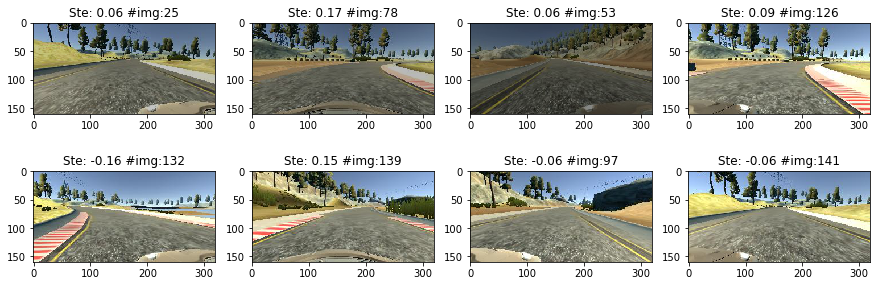

In [5]:
print('images Shape: ', x1.shape)
print('steering Shape: ', y1.shape)
displayImg(x1, y1)

Angle Data Len:  10627


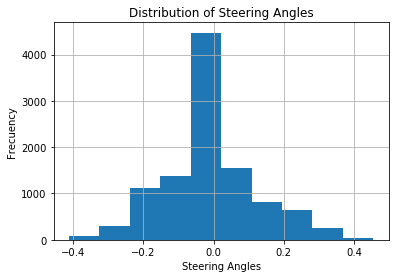

In [6]:
# print(tPaths[0])
yLabel =[]
a = 0
for j in range(len(tPaths)):
    iC,iL,iR,s = tPaths[j].split(',')
    steeringM = float(s)
    yLabel.append(steeringM)
    if steeringM == 0: a+=1
   
print('Angle Data Len: ',len(yLabel))
steeringhistogram(yLabel)

In [7]:
trainingGen = dataTrainingGen(batchSize,tPaths)
validGen = dataValidationGen(batchSize,vPaths)

### Network Architecture

In [8]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import Activation
from keras.optimizers import Adam

Using TensorFlow backend.


In [9]:
model = Sequential()
model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x / 255.0 - 0.5))

# Layer 1 to 3 Convolution, kernel=5x5, Stride=2x2, Activation='Relu', Padding='Valid'
model.add(Conv2D(24,5,strides=2,activation='relu', padding='valid'))
model.add(Conv2D(36,5,strides=2,activation='relu', padding='valid'))
model.add(Conv2D(48,5,strides=2,activation='relu', padding='valid'))

# Layer 4 to 5 Convolution, kernel=3x3, No Stride, Activation='Relu', Padding='Valid'
model.add(Conv2D(64,3,activation='relu', padding='valid'))
model.add(Conv2D(64,3,activation='relu', padding='valid'))

model.add(Flatten())
# model.add(Dense(1164))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
# adam = Adam(lr = 0.0001)
model.compile(loss='mse', optimizer= 'adam')

history_object = model.fit_generator(trainingGen, steps_per_epoch=math.ceil(len(tPaths)/batchSize), epochs=3, verbose=1, validation_data=validGen, validation_steps=math.ceil(len(vPaths)/batchSize), initial_epoch=0)
model.save('model.h5')
print('Done...')

Epoch 1/3
71/71 [==============================] - 510s - loss: 0.0086 - val_loss: 0.0041

dict_keys(['val_loss', 'loss'])


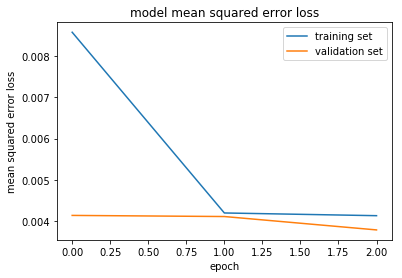

In [10]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()